**NOTE:** *The slope-deflection sign convention may seem strange to those used to matirx stiffness analysis, but it makes sense.  None of the slope deflection equations explicitly state a 
member 'direction' and it doesn't matter.  For example, whether you consider the column AB as
going from A to B or as going from B to A, a +ive shear at end A is still directed toward the
left. In matrix analysis, that direction matters.*

## Kulak & Grondin - Example 8.2
This solves a close approximation to the first-order example of Kulak and Grondin.  The major
differences are:
* the lateral resistance of the outside column stacks are ignored; only the central rigid frame is included.
* this method does not account for axial changes of length in any of the members.
The results obtained here are 
compared with those obtained via a [first-order matrix analysis](../matrix-methods/frame2d/50-test-KG82sd.ipynb),
and found to agree to about 6 significant figures.

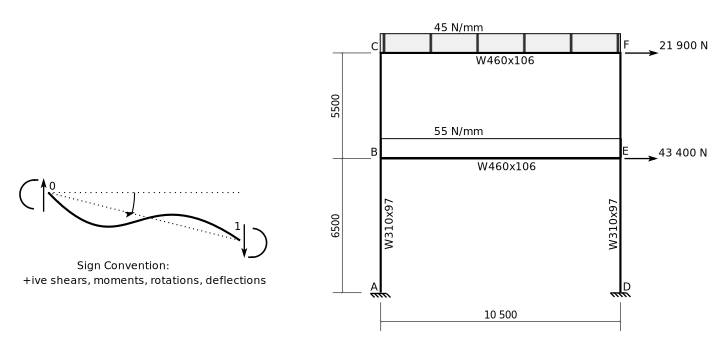

In [1]:
from IPython import display
display.SVG('KG-8.2sd.svg')

### Solve for joint rotations and storey translations using slope-deflection

In [2]:
import sympy as sy                  # use symbolic algebra
sy.init_printing()                  # print pretty math
from sdutil2 import SD, FEF         # slope-deflection library

In [3]:
sy.var('theta_a theta_b theta_c theta_d theta_e theta_f Delta_b Delta_c')

In [4]:
E = 200000
Ic = 222E6   # W310x97
Ib = 488E6   # W460x106
Hf = 21900   # Horizontal load at F
He = 43400   # Horizontal load at E

Lab = 6500   # Length of column
Lbc = 5500   # Length of column
Lbe = 10500  # Length of beam

In [5]:
Mab,Mba,Vab,Vba = SD(Lab,E*Ic,theta_a,theta_b,Delta_b)             # column AB, BC
Mbc,Mcb,Vbc,Vcb = SD(Lbc,E*Ic,theta_b,theta_c,Delta_c-Delta_b)

Mde,Med,Vde,Ved = SD(Lab,E*Ic,theta_d,theta_e,Delta_b)             # column DE, EF
Mef,Mfe,Vef,Vfe = SD(Lbc,E*Ic,theta_e,theta_f,Delta_c-Delta_b)

Mbe,Meb,Vbe,Veb = SD(Lbe,E*Ib,theta_b,theta_e) + FEF.udl(Lbe,55)   # beams BE, CF
Mcf,Mfc,Vcf,Vfc = SD(Lbe,E*Ib,theta_c,theta_f) + FEF.udl(Lbe,45)

In [6]:
eqns = [ Mba+Mbe+Mbc,      # sum of moments at B = 0
         Mcb+Mcf,          # sum of moments at C = 0
         Med+Meb+Mef,      # sum of moments at E = 0
         Mfe+Mfc,          # sum of moments at F = 0
         -Vab-Vde+Hf+He,   # sum of Fx @ base of storey 1 = 0
         -Vbc-Vef+Hf,      # sum of Fx @ base of storey 2 = 0
         theta_a,          # fixed support at A, rotation = 0
         theta_d]          # fixed support at F, rotation = 0

In [7]:
soln = sy.solve(eqns)
soln

### Determine end moments and shears

#### Demonstrate how to access and convert one end moment:

In [8]:
Mab

In [9]:
Mab.subs(soln)

In [10]:
Mab.subs(soln).n(4) * 1E-6

In [11]:
V = globals()   # another way to access global variables
V['Mab']

In [12]:
Mab is V['Mab']

True

In [13]:
V['Mab'].subs(soln).n()

#### Determine end moments by back substitution:

In [14]:
# collect the end moments in all 6 members
allm = []
V = globals()
for m in 'ab,bc,de,ef,be,cf'.split(','):
    mj = V['M'+m].subs(soln).n()*1E-6          # Mxy
    mk = V['M'+m[::-1]].subs(soln).n()*1E-6    # Myx
    allm.append((m.upper(),mj,mk))
allm

[('AB', -49.9080183705027, 47.4941396356060),
 ('BC', 250.526060428376, 252.096857589821),
 ('DE', -189.782099213905, -232.254022051198),
 ('EF', -290.011616822927, -333.061301195269),
 ('BE', -298.020200063982, 522.265638874126),
 ('CF', -252.096857589821, 333.061301195269)]

In [15]:
[(m,round(a,1),round(b,1)) for m,a,b in allm]  # display to one decimal place

[('AB', -49.9, 47.5),
 ('BC', 250.5, 252.1),
 ('DE', -189.8, -232.3),
 ('EF', -290.0, -333.1),
 ('BE', -298.0, 522.3),
 ('CF', -252.1, 333.1)]

#### Determine end shears by back substitution:

In [16]:
# collect the end shears in all 6 members
allv = []
V = globals()
for m in 'ab,bc,de,ef,be,cf'.split(','):
    mj = V['V'+m].subs(soln).n()*1E-3          # Mxy
    mk = V['V'+m[::-1]].subs(soln).n()*1E-3    # Myx
    allv.append((m.upper(),mj,mk))
allv

[('AB', 0.371365959214883, 0.371365959214883),
 ('BC', -91.3859850942176, -91.3859850942176),
 ('DE', 64.9286340407851, 64.9286340407851),
 ('EF', 113.285985094218, 113.285985094218),
 ('BE', 267.393291541891, -310.106708458109),
 ('CF', 228.539100609005, -243.960899390995)]

In [17]:
[(m,round(a,1),round(b,1)) for m,a,b in allv]   # display to one decimal place

[('AB', 0.4, 0.4),
 ('BC', -91.4, -91.4),
 ('DE', 64.9, 64.9),
 ('EF', 113.3, 113.3),
 ('BE', 267.4, -310.1),
 ('CF', 228.5, -244.0)]

### Now compare to matrix method solution (Frame2D):

In [18]:
import pandas as pd

dd = '../matrix-methods/frame2d/data/KG82sd.d/all'   # location of mm solution

### Compare Moments:
#### Convert current member end moments solution to tabular form:

In [19]:
mems = pd.DataFrame(allm,columns=['ID','MZJ','MZK']).set_index('ID')
mems

,MZJ,MZK
ID,,
AB,-49.9080183705027,47.4941396356060
BC,250.526060428376,252.096857589821
DE,-189.782099213905,-232.254022051198
EF,-290.011616822927,-333.061301195269
BE,-298.020200063982,522.265638874126
CF,-252.096857589821,333.061301195269


#### Fetch solution from Frame2D:

In [20]:
mefs = pd.read_csv(dd+'/member_end_forces.csv').set_index('MEMBERID').loc[mems.index]
mems2 = mefs[['MZJ','MZK']] * -1E-6    # convert sign and to kN-m
mems2

,MZJ,MZK
ID,,
AB,-49.908014,47.494144
BC,250.526061,252.096859
DE,-189.782098,-232.254022
EF,-290.011612,-333.061297
BE,-298.020204,522.265634
CF,-252.096859,333.061297


#### Compare member end moments in the two solutions:

In [21]:
mdiff = (100*(1-mems/mems2))   # calculate % diff
mdiff

,MZJ,MZK
ID,,
AB,-9.17049660653646e-6,8.35047321290361e-6
BC,9.14187947564926e-8,6.57745258259013e-7
DE,-5.40915578994827e-7,4.17979983957650e-8
EF,-1.72059335667996e-6,-1.36026414576662e-6
BE,1.40762708156217e-6,-9.36849420263286e-7
CF,6.57745302667934e-7,-1.36026414576662e-6


In [22]:
mdiff.abs().max()

MZJ    0.000009
MZK    0.000008
dtype: float64

The maximum difference in member end moments is 0.000009% (about 7 or 8 sig figs).

### Compare Shears:

#### Convert our end shears to tabular form:

In [23]:
mevs = pd.DataFrame(allv,columns=['ID','FYJ','FYK']).set_index('ID')
mevs

,FYJ,FYK
ID,,
AB,0.371365959214883,0.371365959214883
BC,-91.3859850942176,-91.3859850942176
DE,64.9286340407851,64.9286340407851
EF,113.285985094218,113.285985094218
BE,267.393291541891,-310.106708458109
CF,228.539100609005,-243.960899390995


#### Extract the end shears from Frame2D results:

In [24]:
mevs2 = mefs[['FYJ','FYK']] * 1E-3
mevs2[['FYK']] *= -1    # change sign on end k
mevs2

,FYJ,FYK
ID,,
AB,0.371365,0.371365
BC,-91.385985,-91.385985
DE,64.928634,64.928634
EF,113.285983,113.285983
BE,267.393292,-310.106708
CF,228.539101,-243.960899


#### Compare end shears in the two results:

In [25]:
vdiff = 100*(1-mevs/mevs2)
vdiff

,FYJ,FYK
ID,,
AB,-0.000353904629113444,-0.000353904629113444
BC,3.75466946422875e-7,3.75466946422875e-7
DE,-2.20237894588138e-7,-2.20237894588138e-7
EF,-1.52798038666191e-6,-1.52798038666191e-6
BE,3.23684223868526e-7,-2.79100675903976e-7
CF,2.57897703193066e-7,-2.41594921845945e-7


In [26]:
vdiff.abs().max()

FYJ    0.000354
FYK    0.000354
dtype: float64

The maximum difference is about 0.00004% which is high, but end shears on column AB are very small.

### Compare Displacements

In [27]:
deltw = pd.DataFrame([('B', soln[Delta_b], soln[theta_b]),
                      ('C', soln[Delta_c], soln[theta_c])],columns=['ID','DX','RZ']).set_index('ID')
deltw

,DX,RZ
ID,,
B,23.3628188885579,0.00712966246666336
C,34.3068306465552,0.00722695283139248


In [28]:
disp = pd.read_csv(dd+'/node_displacements.csv').set_index('NODEID').loc[deltw.index][['DX','RZ']]
disp['RZ'] *= -1
disp

,DX,RZ
ID,,
B,23.362818,0.007130
C,34.306830,0.007227


In [29]:
diffd = (100*(1-deltw/disp))
diffd

,DX,RZ
ID,,
B,-3.52157611960280e-6,-6.27118601492782e-7
C,-2.71776707805316e-6,6.06124439528344e-7


In [30]:
diffd.abs().max()

DX    3.521576e-06
RZ    6.271186e-07
dtype: float64

Max difference in displacement is 0.000006%.

Note that the matrix method solution was accomplished by setting A very high in order to minimize
effects of axial deformation.  But there is a limit to how high this can be set, due to numerical
instability in equation solving (probably).  Setting $A=10^{10}$ seems to be about as high as is possible - larger values lead to worse results.